# Tutorial 03

## Cats vs Dogs
From Tutorial 01. Dataset can be downloaded from http://files.fast.ai/data/dogscats.zip  
**Classification task**, two classes

FULL COLAB LINK: https://colab.research.google.com/drive/1vPI7-sIBSotI7YG4IKD2zSgiEnyOGd5n

In [1]:
# # CHANGE THE RUNTIME TO GPU BEFORE RUNNING THIS. Runtime / Change runtime type / Hardware accelerator: GPU
# !wget http://files.fast.ai/data/dogscats.zip
# !unzip dogscats.zip

In [2]:
# !pip install -U tqdm

# Training neural networks
We have a set of input vectors $x$ (features) and desired targets (value / class label) $y$  
We want to find a function $f$ such that $f(x)=y$

Basic training algorithm:  
**Input:**
- features $x$, targets $y$  
- neural network model with randomly initialized parameters $\theta$: $f(x; \theta)$  
- learning_rate $\alpha$  
- loss function $L$  

**Output:**
- optimized parameters $\theta$

**Algorithm**  
>for epoch in 1..n_epochs do:
>>     for (minibatch_x, minibatch_y) in dataset do
>>>        compute predicted y' = f(x; theta)
>>>        compute loss = L(y', minibatch_y)
>>>        compute gradients = gradient(L, theta)
>>>        update parameters theta <- theta - alpha * gradients

In [3]:
import torch
from tqdm.notebook import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
root_dir = '../data/dogscats/train'

target_size = (32, 32)
transforms = Compose([Resize(target_size), # Resizes image
                    ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_dataset_ = ImageFolder(root_dir, transform=transforms)

In [5]:
len(train_dataset_)

23000

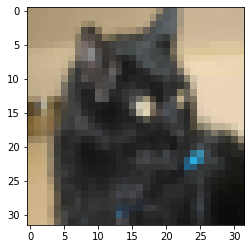

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow((train_dataset_[101][0]*0.5+0.5).numpy().transpose(1, 2, 0))

In [7]:
class RAMDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        data = []
        for sample in tqdm(dataset):
            data.append(sample)
        self.n = len(dataset)
        self.data = data
        
    def __getitem__(self, ind):
        return self.data[ind]
    
    def __len__(self):
        return self.n

train_dataset = RAMDatasetWrapper(train_dataset_)

In [8]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) #num_workers = n - how many threads in background for efficient loading

In [9]:
# Same for validation dataset
val_root_dir = '../data/dogscats/valid'
val_dataset_ = ImageFolder(val_root_dir, transform=transforms)
val_dataset = RAMDatasetWrapper(val_dataset_)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
print(len(val_dataset))

2000


In [11]:
import torch.nn as nn
class LinearModel(nn.Module):
    
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, 2, bias=True) # outputs 2 values - score for cat and score for dog
        
    def forward(self, input):
        out = input.view(input.size(0), -1) # convert batch_size x 3 x imH x imW to batch_size x (3*imH*imW)
        out = self.fc(out) # Applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return out
    
class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [12]:
import numpy as np

model = LinearModel(32*32*3)
model = model.to(device)

# Initialize loss function, optimizer and parameters
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    # Return mean loss and accuracy
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
model = LinearModel(32*32*3)
model = model.to(device)

# Initialize loss function, optimizer and parameters
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25

train_losses, val_losses, train_acc, val_acc = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)


Epoch 1/25: train_loss: 0.6768, train_accuracy: 57.5087, val_loss: 0.6665, val_accuracy: 60.2500



Epoch 2/25: train_loss: 0.6650, train_accuracy: 59.4087, val_loss: 0.6613, val_accuracy: 60.3500



Epoch 3/25: train_loss: 0.6603, train_accuracy: 60.2522, val_loss: 0.6602, val_accuracy: 61.3500



Epoch 4/25: train_loss: 0.6569, train_accuracy: 60.9609, val_loss: 0.6592, val_accuracy: 61.8500



Epoch 5/25: train_loss: 0.6543, train_accuracy: 61.2652, val_loss: 0.6543, val_accuracy: 62.2000



Epoch 6/25: train_loss: 0.6519, train_accuracy: 61.7174, val_loss: 0.6526, val_accuracy: 62.1000



Epoch 7/25: train_loss: 0.6504, train_accuracy: 61.8261, val_loss: 0.6508, val_accuracy: 62.5000



Epoch 8/25: train_loss: 0.6489, train_accuracy: 61.7913, val_loss: 0.6501, val_accuracy: 63.0500



Epoch 9/25: train_loss: 0.6475, train_accuracy: 62.0522, val_loss: 0.6497, val_accuracy: 62.3500



Epoch 10/25: train_loss: 0.6465, train_accuracy: 62.6652, val_loss: 0.6504, val_accuracy: 62.7000



Epoch 11/25: train_loss: 0.6455, train_accuracy: 62.4565, val_loss: 0.6496, val_accuracy: 62.4000



Epoch 12/25: train_loss: 0.6445, train_accuracy: 62.4739, val_loss: 0.6516, val_accuracy: 62.2500



Epoch 13/25: train_loss: 0.6436, train_accuracy: 62.6609, val_loss: 0.6478, val_accuracy: 63.6000



Epoch 14/25: train_loss: 0.6430, train_accuracy: 62.6609, val_loss: 0.6479, val_accuracy: 62.9000



Epoch 15/25: train_loss: 0.6416, train_accuracy: 63.2783, val_loss: 0.6455, val_accuracy: 63.9000



Epoch 16/25: train_loss: 0.6416, train_accuracy: 63.1087, val_loss: 0.6495, val_accuracy: 63.4000



Epoch 17/25: train_loss: 0.6408, train_accuracy: 63.1826, val_loss: 0.6476, val_accuracy: 63.2000



Epoch 18/25: train_loss: 0.6399, train_accuracy: 63.2522, val_loss: 0.6481, val_accuracy: 63.1500



Epoch 19/25: train_loss: 0.6400, train_accuracy: 63.6522, val_loss: 0.6468, val_accuracy: 63.7500



Epoch 20/25: train_loss: 0.6396, train_accuracy: 63.7000, val_loss: 0.6487, val_accuracy: 62.3500



Epoch 21/25: train_loss: 0.6390, train_accuracy: 63.7391, val_loss: 0.6455, val_accuracy: 63.2000



Epoch 22/25: train_loss: 0.6388, train_accuracy: 63.7478, val_loss: 0.6446, val_accuracy: 63.6500



Epoch 23/25: train_loss: 0.6381, train_accuracy: 63.5565, val_loss: 0.6453, val_accuracy: 64.1000



Epoch 24/25: train_loss: 0.6376, train_accuracy: 63.7652, val_loss: 0.6468, val_accuracy: 62.9500



Epoch 25/25: train_loss: 0.6370, train_accuracy: 63.9609, val_loss: 0.6468, val_accuracy: 63.4000


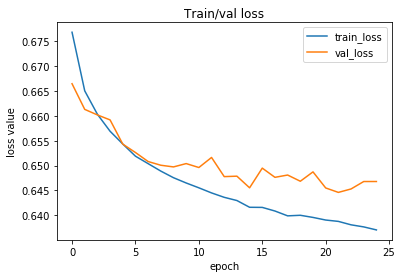

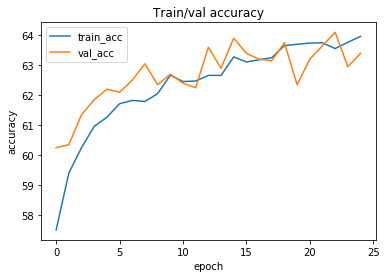

In [14]:
# np.savez('losses_linear_lr1e-3.npz', train_losses=train_losses, val_losses=val_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies)
# linear_model_data = np.load('losses_linear_lr1e-3.npz')
# train_losses, val_losses, train_accuracies, val_accuracies = linear_model_data['train_losses'], linear_model_data['val_losses'], linear_model_data['train_accuracies'], linear_model_data['val_accuracies']

def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(np.arange(n_epochs), train_losses)
    plt.plot(np.arange(n_epochs), val_losses)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss');

    plt.figure()
    plt.plot(np.arange(n_epochs), train_accuracies)
    plt.plot(np.arange(n_epochs), val_accuracies)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy');

plot(n_epochs, train_losses, val_losses, train_acc, val_acc)

In [15]:
model = MLPModel(32*32*3, 64)
model = model.to(device)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_function = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function)


Epoch 1/25: train_loss: 0.6527, train_accuracy: 60.9130, val_loss: 0.6315, val_accuracy: 63.7500



Epoch 2/25: train_loss: 0.6197, train_accuracy: 65.1348, val_loss: 0.6253, val_accuracy: 64.2500



Epoch 3/25: train_loss: 0.6019, train_accuracy: 66.9130, val_loss: 0.6156, val_accuracy: 65.3500



Epoch 4/25: train_loss: 0.5860, train_accuracy: 68.3609, val_loss: 0.6142, val_accuracy: 65.2500



Epoch 5/25: train_loss: 0.5722, train_accuracy: 69.7913, val_loss: 0.6086, val_accuracy: 66.5000



Epoch 6/25: train_loss: 0.5563, train_accuracy: 70.8870, val_loss: 0.6090, val_accuracy: 66.9000



Epoch 7/25: train_loss: 0.5443, train_accuracy: 71.8304, val_loss: 0.6062, val_accuracy: 67.7500



Epoch 8/25: train_loss: 0.5302, train_accuracy: 72.4739, val_loss: 0.6306, val_accuracy: 66.6500



Epoch 9/25: train_loss: 0.5170, train_accuracy: 73.5652, val_loss: 0.6222, val_accuracy: 67.5000



Epoch 10/25: train_loss: 0.5023, train_accuracy: 74.8130, val_loss: 0.6298, val_accuracy: 67.5500



Epoch 11/25: train_loss: 0.4907, train_accuracy: 75.4304, val_loss: 0.6512, val_accuracy: 65.7000



Epoch 12/25: train_loss: 0.4766, train_accuracy: 76.4174, val_loss: 0.6555, val_accuracy: 66.7500



Epoch 13/25: train_loss: 0.4626, train_accuracy: 77.1652, val_loss: 0.6562, val_accuracy: 66.6000



Epoch 14/25: train_loss: 0.4457, train_accuracy: 78.4087, val_loss: 0.7209, val_accuracy: 65.1000



Epoch 15/25: train_loss: 0.4336, train_accuracy: 79.2783, val_loss: 0.7179, val_accuracy: 67.2500



Epoch 16/25: train_loss: 0.4222, train_accuracy: 79.6217, val_loss: 0.7188, val_accuracy: 66.0500



Epoch 17/25: train_loss: 0.4055, train_accuracy: 80.8609, val_loss: 0.7480, val_accuracy: 66.5000



Epoch 18/25: train_loss: 0.3966, train_accuracy: 81.1261, val_loss: 0.7547, val_accuracy: 65.6500



Epoch 19/25: train_loss: 0.3820, train_accuracy: 81.9261, val_loss: 0.7567, val_accuracy: 65.5000



Epoch 20/25: train_loss: 0.3730, train_accuracy: 82.6565, val_loss: 0.8386, val_accuracy: 67.4000



Epoch 21/25: train_loss: 0.3607, train_accuracy: 83.1913, val_loss: 0.8498, val_accuracy: 65.4000



Epoch 22/25: train_loss: 0.3466, train_accuracy: 83.9130, val_loss: 0.8741, val_accuracy: 65.2500



Epoch 23/25: train_loss: 0.3357, train_accuracy: 84.5565, val_loss: 0.8520, val_accuracy: 66.4500



Epoch 24/25: train_loss: 0.3282, train_accuracy: 84.9565, val_loss: 0.8926, val_accuracy: 65.0000



Epoch 25/25: train_loss: 0.3179, train_accuracy: 85.5087, val_loss: 0.9025, val_accuracy: 65.2500


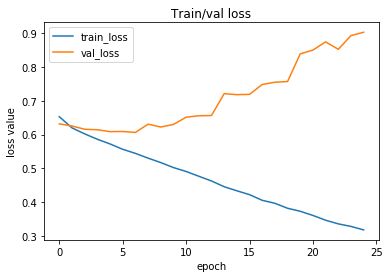

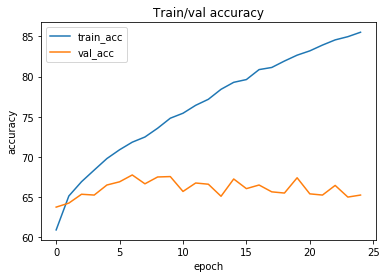

In [16]:
plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)